# Spectral Fitting

This notebook measures aperiodic activity using various different spectral fitting measures.

There have been many variations for fitting power spectra. This notebook compares different strategies.

This notebooks covers:
- Linear fits to power spectra in log-log spacing, using a simple (OLS) linear fit
- Linear fits to power spectra in log-log spacing, using a robust (RLM) linear fit
- Linear fits to power spectra in log-log spacing, using the RANSAC robust fitting algorithm
- Exponential fits to power spectra in semi-log spacing, using a simple exponential fit

In addition, various studies have used simple heuristics to try and fit aperiodic activity while avoiding being biased by peaks. 

In this comparison, we include the following variations of the aforementioned methods:
- Fitting the entire frequency range 
- Using a predefined exclusion zone of the alpha oscillation (7-14 Hz)
- Using exclusing zones for all oscillatory peaks*

Finally, these fits are all compared to the 
[spectral parameterization](https://fooof-tools.github.io/)
algorithm.

*Note that this approach uses spectral parameterization to detect and exclude oscillatory regions.


ToDos:
- fix up error plots (setting size and using savefig)
- adjust parameters to sweep across (extend a bit)
- check SpecParam settings
- show more PSD simulations (in sims notebook)

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor
from scipy.stats.mstats import normaltest

from fooof import FOOOF
from fooof.core.funcs import expo_nk_function as expf
from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [5]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.methods import SpectralFits
from apm.methods.fit import *
from apm.plts import plot_psds, plot_psds_two, plot_psds_shades
from apm.plts.errors import violin_errors, boxplot_errors
from apm.plts.utils import color_red_or_green

from apm.utils import exclude_spectrum, print_results

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

## Settings

In [6]:
# Set up project database object
db = APMDB()

In [7]:
# Simulation settings
f_range = [3, 40]
off_val = 0
noise = 0.0

In [8]:
# Notebook Settings
SAVE_FIG = False
SAVE_DATA = False

## Spectral Fitting Methods

Here we demonstrate spectral fitting methods for measuring the aperiodic exponent by directly fitting power spectra.

The implementations of these methods are available in `apm/fit.py`.

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [9]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

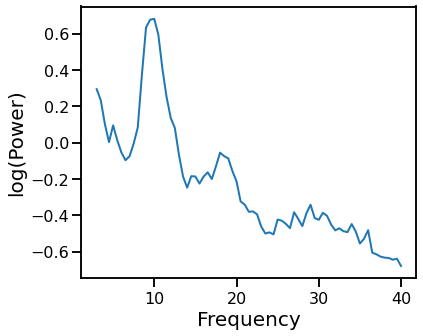

In [10]:
# Check a plot of the loaded power spectrum
plot_psds(freqs, psd)

## Methods for Fitting Power Spectra

Here, we introduce the various methods for fitting the aperiodic component of the power spectrum. 

In [11]:
# Initialize for collecting example fit results
example_results = {}

In [12]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

### OLS Linear Fit

Fit a line in log-log with Ordinary Least Squares (OLS).

In [13]:
# Spectral fit: linear fit
ex_fit_ols = sm.OLS(np.log10(psd), fx).fit()
example_results['ols'] = ex_fit_ols.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols.fittedvalues)

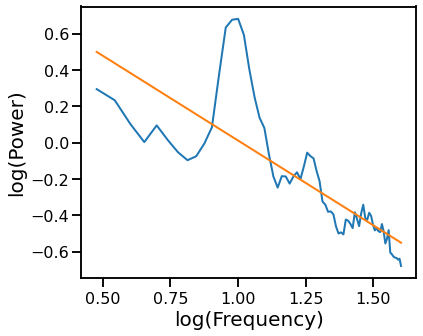

In [14]:
# Plot the aperiodic fit, from the OLS linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM

In [15]:
# Spectral fit: robust linear fit to log-log PSD
ex_fit_rlm = sm.RLM(np.log10(psd), fx).fit()
example_results['rlm'] = ex_fit_rlm.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm.fittedvalues)

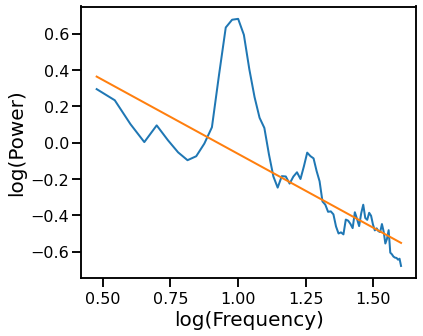

In [16]:
# Plot the aperiodic fit, from the robust linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC

In [17]:
# Reshape freqs for RANSAC fit
freqs_ran = freqs.reshape([len(freqs), 1])

In [18]:
# Initialize and fit with RANSAC
ex_ransac_model = RANSACRegressor()
ex_ransac_model.fit(np.log10(freqs_ran), np.log10(psd))
example_results['ran'] = ex_ransac_model.estimator_.coef_[0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model.predict(np.log10(freqs_ran)))

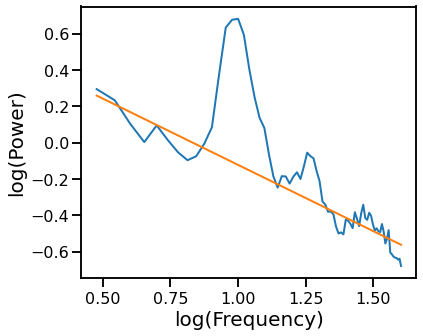

In [19]:
# Plot the aperiodic fit, from RANSAC
plot_psds(freqs_ran.flatten(), [psd, pred_vals], log_freqs=True)

## Spectral Fitting Excluding Alpha

Use a specific exclusion zone for the alpha oscillation.

In [20]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_spectrum(np.squeeze(freqs), psd, [7, 14])#, False)

# Reset freqs, with constant
fx_alph = sm.add_constant(np.log10(freqs_alph))

### Simple OLS Linear Fit Exlucing Generic Alpha Band

In [21]:
# Linear fit without alpha range
ex_fit_ols_alph = sm.OLS(np.log10(psd_alph), fx_alph).fit()
example_results['ols_alph'] = ex_fit_ols_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_alph.fittedvalues)

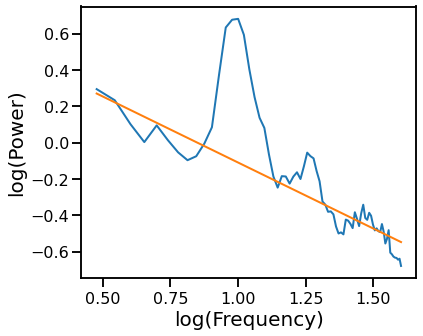

In [22]:
# Plot the aperiodic fit, from an OLS linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Generic Alpha Band

In [23]:
# Robust fit without alpha range
ex_fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx_alph).fit()
example_results['rlm_alph'] = ex_fit_rlm_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_alph.fittedvalues)

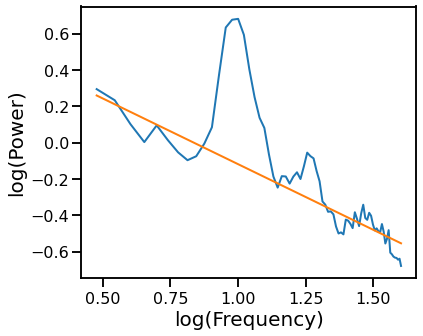

In [24]:
# Plot the aperiodic fit, from the robust linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC Excluding Generic Alpha Band

In [25]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_alph = RANSACRegressor()
ex_ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
example_results['ran_alph'] = ex_ransac_model_alph.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_alph.predict(np.log10(freqs_alph)))

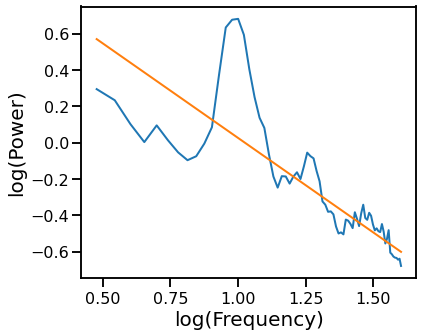

In [26]:
# Plot the aperiodic fit, from the RANSAC fit with alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

## Spectral Fit Excluding Oscillations

Use a exclusion zones for oscillations.

In [27]:
# Fit spectral model for finding peaks
fm = FOOOF(peak_width_limits=[1, 8])
fm.fit(freqs, psd, [3, 40])

In [28]:
# Get oscillation definitions from FOOOF
cens = fm.gaussian_params_[:, 0]
bws = fm.gaussian_params_[:, 2]

# Define oscillation ranges, as a range around each center frequency
m = 2
osc_ranges = [[cen-m*bw, cen+m*bw] for cen, bw in zip(cens, bws)]

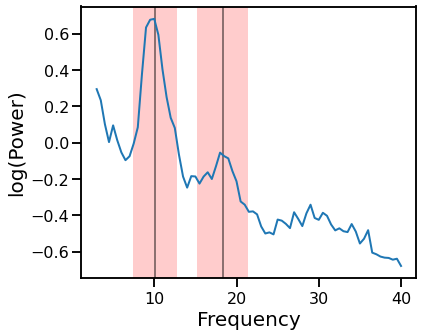

In [29]:
# Plot PSD with oscillatory regions shaded
plot_psds_shades(freqs, psd, osc_ranges)

In [30]:
# Exclude oscillation bands, as measured from FOOOF
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_spectrum(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

In [31]:
# Create a frequency vector with exlcusion zones for model fitting
fx_excl = sm.add_constant(np.log10(freqs_excl))

### Simple Linear Fit Excluding Oscillatory Bands

In [32]:
# Linear fit without alpha range
ex_fit_ols_excl = sm.OLS(np.log10(psd_excl), fx_excl).fit()
example_results['ols_excl'] = ex_fit_ols_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_excl.fittedvalues)

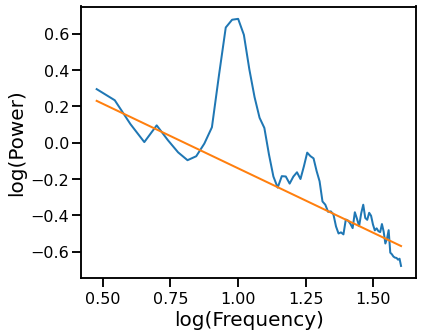

In [33]:
# Plot the aperiodic fit, from the OLS linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Oscillatory Bands

In [34]:
# Robust fit without oscillation bands
ex_fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx_excl).fit()
example_results['rlm_excl'] = ex_fit_rlm_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_excl.fittedvalues)

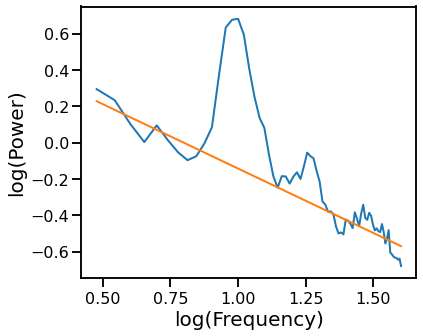

In [35]:
# Plot the aperiodic fit, from the robust linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC Excluding Oscillatory Bands

In [36]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_excl = RANSACRegressor()
ex_ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
example_results['ran_excl'] = ex_ransac_model_excl.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_excl.predict(np.log10(freqs_excl)))

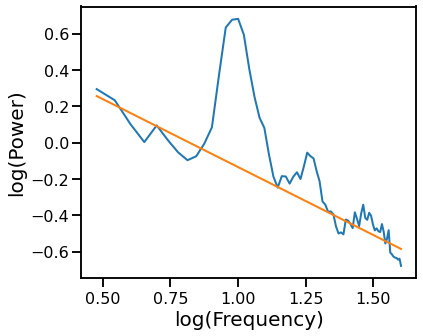

In [37]:
# Plot the aperiodic fit, from the RANSAC fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

## Exponential Fits

### Exponential Fit

In [38]:
# Fit exponential 1/f, with scipy curve_fit
ex_fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
example_results['exp'] = -ex_fit_exp[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs, *ex_fit_exp))

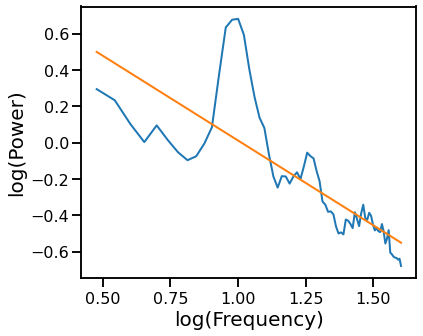

In [39]:
# Plot the aperiodic fit, from the exponential fit
plot_psds(freqs.flatten(), [psd, pred_vals], log_freqs=True)

### Exponential Fit Excluding Alpha Region

In [40]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
ex_fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
example_results['exp_alph'] = -ex_fit_exp_alph[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_alph, *ex_fit_exp_alph))

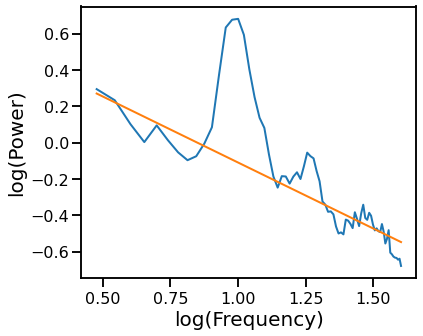

In [41]:
# Plot the aperiodic fit, from the exponential fit, with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Exponential Fit Excluding Oscillation Regions

In [42]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
ex_fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
example_results['exp_excl'] = -ex_fit_exp_excl[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_excl, *ex_fit_exp_excl))

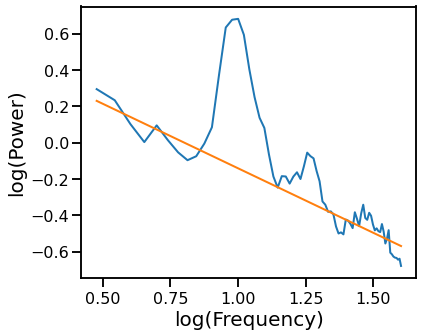

In [43]:
# Plot the aperiodic fit, from the exponential fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

## Spectral Parameterization


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

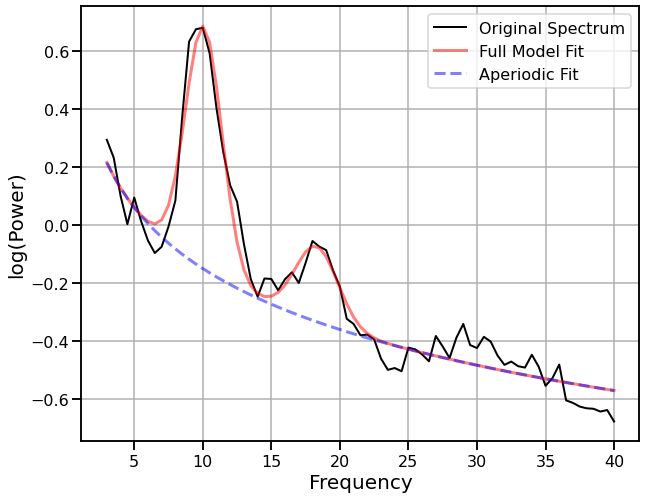

In [44]:
# Fit the SpecParam model
fm = FOOOF()
fm.report(freqs, psd, [3, 40])
example_results['fooof'] = -fm.aperiodic_params_[1]

## Compare Example Fits

In [45]:
# Print out results across all the different approaches
print('FIT RESULTS')
for key, val in example_results.items():
    print('  {:10s} \t {:1.3f}'.format(key, val))

FIT RESULTS
  ols        	 -0.933
  rlm        	 -0.813
  ran        	 -0.729
  ols_alph   	 -0.726
  rlm_alph   	 -0.723
  ran_alph   	 -1.040
  ols_excl   	 -0.710
  rlm_excl   	 -0.709
  ran_excl   	 -0.748
  exp        	 -0.933
  exp_alph   	 -0.726
  exp_excl   	 -0.710
  fooof      	 -0.700


In [46]:
# Check fits ordered by magnitude
for key, val  in dict(sorted(example_results.items(), key=lambda it: it[1])).items():
    print('{:10s} \t {:1.5f}'.format(key, val))

ran_alph   	 -1.04039
ols        	 -0.93306
exp        	 -0.93306
rlm        	 -0.81338
ran_excl   	 -0.74777
ran        	 -0.72937
exp_alph   	 -0.72646
ols_alph   	 -0.72646
rlm_alph   	 -0.72290
exp_excl   	 -0.70999
ols_excl   	 -0.70999
rlm_excl   	 -0.70878
fooof      	 -0.69973


## Simulation Tests

Now that we have introduced the different methods, we will systematically evaluatate them across simulated data.

In [47]:
# Initialize and set up for simulated data testing
fits = SpectralFits()

In [48]:
# Check the fitting functions being used
print(fits.labels)

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


## Check out PSD generation and test fitting

In [59]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()
peaks = next(peak_gen)

In [60]:
# Simulate an example power spectrum
freqs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

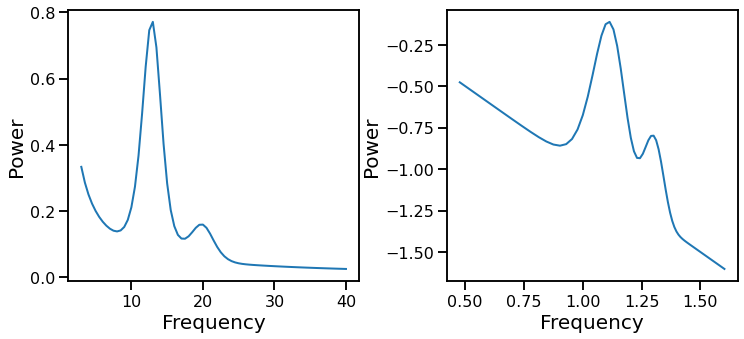

In [61]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [62]:
# Check example fits
print('Example fits for true exponent value of {:d}:'.format(exp_val))
for name, func in fits.fit_funcs.items():
    print('  {:5s} \t {:1.3f}'.format(name, func(freqs, psd)))

Example fits for true exponent value of 1:
  OLS   	 -1.206
  OLS-EA 	 -1.089
  OLS-EO 	 -1.017
  RLM   	 -1.112
  RLM-EA 	 -1.014
  RLM-EO 	 -1.001
  RAN   	 -1.057
  RAN-EA 	 -2.088
  RAN-EO 	 -1.009
  EXP   	 -1.206
  EXP-EA 	 -1.089
  EXP-EO 	 -1.017
  FOOOF 	 -1.009


## Run Spectral Fits on Simulated Power Spectra

Run spectral fitting across multiple exponents and noise levels.

In [63]:
# Spectrum Settings
N_SPECTRA = 50
F_RANGE = [3, 40]

# Simulation Settings
NOISE_VALS = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
EXP_VALS = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Set verbose setting
VERBOSE = False

In [51]:
# Run all fits
all_fits = SpectralFits()
for exp in EXP_VALS:
    for noise in NOISE_VALS:

        if VERBOSE:
            print('Running sims for exponent val {}, noise-val {}'.format(exp, noise))

        # Simulate set of power spectra
        freqs, psds, sim_params = gen_group_power_spectra(\
            N_SPECTRA, F_RANGE, [off_val, exp], gen_peak_def(), noise, return_params=True)

        # Initialize SimFit object, and run fits
        fits = SpectralFits()
        fits.fit_spectra(exp, freqs, psds)
        
        # Collect results together
        all_fits = all_fits + fits

        # Save out fit data
        if SAVE_DATA:
            save_name = 'SpectralFits_exp' + str(exp) + '_N' + str(noise) + '.p'
            save_pickle(fits.errors, save_name, db.sims_path)

In [52]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
sim_files

['SimFits_exp1.0_N0.0.p',
 'SimFits_exp0.5_N0.1.p',
 'SimFits_exp0.5_N0.15.p',
 'SimFits_exp0.5_N0.05.p',
 'SimFits_exp0.5_N0.01.p',
 'SimFits_test.p',
 'SimFits_exp0.5_N0.2.p',
 'SimFits_exp1.0_N0.1.p',
 'SimFits_exp1.0_N0.01.p',
 'SimFits_exp1.0_N0.05.p',
 'SimFits_exp0.5_N0.0.p']

In [53]:
# # Load specific spectral fits
# f_ind = 0
# fits = SpectralFits()
# fits.errors = load_pickle(sim_files[f_ind], db.sims_path)

In [54]:
# # Reload and combine all fit files
# all_fits = SpectralFits()

# for f_name in sim_files:
#     temp = SpectralFits()
#     temp.errors = load_pickle(f_name, db.sims_path)
#     all_fits = all_fits + temp

## Compare Spectral Fitting

In [55]:
# Check how many PSDs are included in simulated data model fits
print(len(all_fits))

1800


In [56]:
# Check the average errors per method
print('Average error for each method:')
print_results(all_fits.compute_avg_errors(avg='mean'))

Average error for each method:
   FOOOF    		 0.06666
   RLM-EA   		 0.06704
   RLM-EO   		 0.06792
   OLS-EO   		 0.07043
   EXP-EO   		 0.07043
   RLM      		 0.08502
   OLS-EA   		 0.08575
   EXP-EA   		 0.08575
   RAN      		 0.09517
   RAN-EO   		 0.09582
   RAN-EA   		 0.10769
   EXP      		 0.11785
   OLS      		 0.11785


In [57]:
# Check the standard deviation of errors per method
print('Standard deviation of the errors for each method:')
print_results(all_fits.compute_std_errors())

Standard deviation of the errors for each method:
   RLM-EA   		 0.11176
   RLM      		 0.12061
   EXP-EA   		 0.12957
   OLS-EA   		 0.12957
   RAN      		 0.13339
   EXP      		 0.15097
   OLS      		 0.15097
   RAN-EA   		 0.19737
   OLS-EO   		 0.21932
   EXP-EO   		 0.21932
   RLM-EO   		 0.21984
   RAN-EO   		 0.29924
   FOOOF    		 nan


In [58]:
# Check the number of fits that pass a threshold, per method
print('Percentage of fits below an error threshold:')
print_results(all_fits.compute_threshold(thresh=0.05))

Percentage of fits below an error threshold:
   RLM-EA   		 0.62944
   RLM-EO   		 0.62778
   OLS-EO   		 0.61667
   EXP-EO   		 0.61667
   FOOOF    		 0.58778
   RAN-EO   		 0.58444
   RLM      		 0.55889
   RAN-EA   		 0.54889
   OLS-EA   		 0.54833
   EXP-EA   		 0.54833
   RAN      		 0.49444
   OLS      		 0.45167
   EXP      		 0.45167


/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/methods/fit.py:148: RuntimeWarning: invalid value encountered in less
  perc_good.append((sum(vals < thresh) / len(vals), key))


/Users/tom/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/tom/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


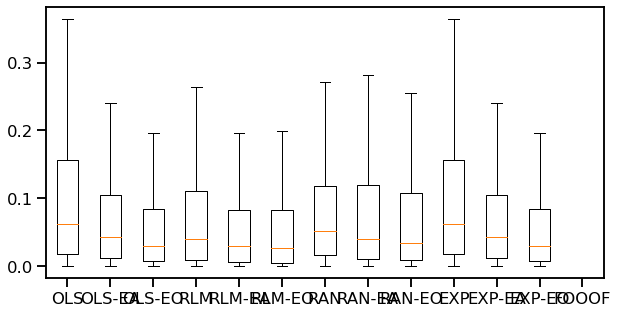

In [59]:
# Create boxplot of errors
boxplot_errors(all_fits.errors)

In [60]:
# Define labels
mains = ['OLS', 'RLM', 'RAN', 'EXP', 'FOOOF']
alphas = ['OLS-EA', 'RLM-EA', 'RAN-EA', 'EXP-EA', 'FOOOF']
oscs = ['OLS-EO', 'RLM-EO', 'RAN-EO', 'EXP-EO', 'FOOOF']

In [61]:
# Split up methods by approach
main_dicts = {label : all_fits.errors[label] for label in mains}
alphas_dicts = {label : all_fits.errors[label] for label in alphas}
oscs_dicts = {label : all_fits.errors[label] for label in oscs}

## Violin Plots

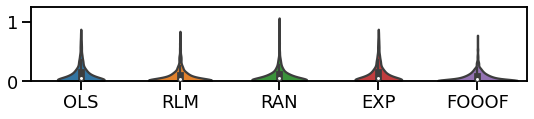

In [62]:
violin_errors(main_dicts, ylim=[0, 1.25])

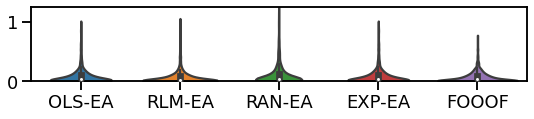

In [63]:
violin_errors(alphas_dicts, ylim=[0, 1.25])

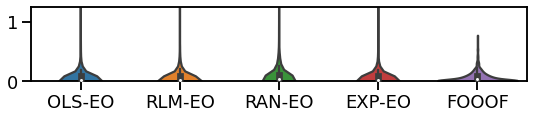

In [64]:
violin_errors(oscs_dicts, ylim = [0, 1.25])

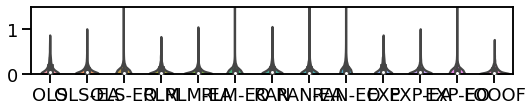

In [65]:
# Violin plot of error distributions
ax = violin_errors(all_fits.errors, ylim=[0, 1.5])

## Statistically Compare Methods

In [66]:
# Create a dataframe of the simulation errors
errors_df = pd.DataFrame(all_fits.errors)

In [67]:
# Check the correlation structure between fit errors
errors_df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.795672,0.173624,0.925016,0.722106,0.141976,0.643864,0.234939,0.157612,1.000000,0.795672,0.173624,0.576257
OLS-EA,0.795672,1.000000,0.227046,0.810160,0.941586,0.197026,0.630059,0.339239,0.206531,0.795672,1.000000,0.227046,0.687629
OLS-EO,0.173624,0.227046,1.000000,0.215563,0.265687,0.994503,0.210472,0.099692,0.865199,0.173624,0.227046,1.000000,0.370728
RLM,0.925016,0.810160,0.215563,1.000000,0.806710,0.191929,0.704805,0.324068,0.215888,0.925016,0.810160,0.215563,0.677011
RLM-EA,0.722106,0.941586,0.265687,0.806710,1.000000,0.245009,0.639780,0.390487,0.252784,0.722106,0.941586,0.265687,0.751387
RLM-EO,0.141976,0.197026,0.994503,0.191929,0.245009,1.000000,0.198513,0.097118,0.867559,0.141976,0.197026,0.994503,0.343027
RAN,0.643864,0.630059,0.210472,0.704805,0.639780,0.198513,1.000000,0.340844,0.189153,0.643864,0.630059,0.210472,0.571015
RAN-EA,0.234939,0.339239,0.099692,0.324068,0.390487,0.097118,0.340844,1.000000,0.112419,0.234939,0.339239,0.099692,0.310832
RAN-EO,0.157612,0.206531,0.865199,0.215888,0.252784,0.867559,0.189153,0.112419,1.000000,0.157612,0.206531,0.865199,0.326065
EXP,1.000000,0.795672,0.173624,0.925016,0.722106,0.141976,0.643864,0.234939,0.157612,1.000000,0.795672,0.173624,0.576257


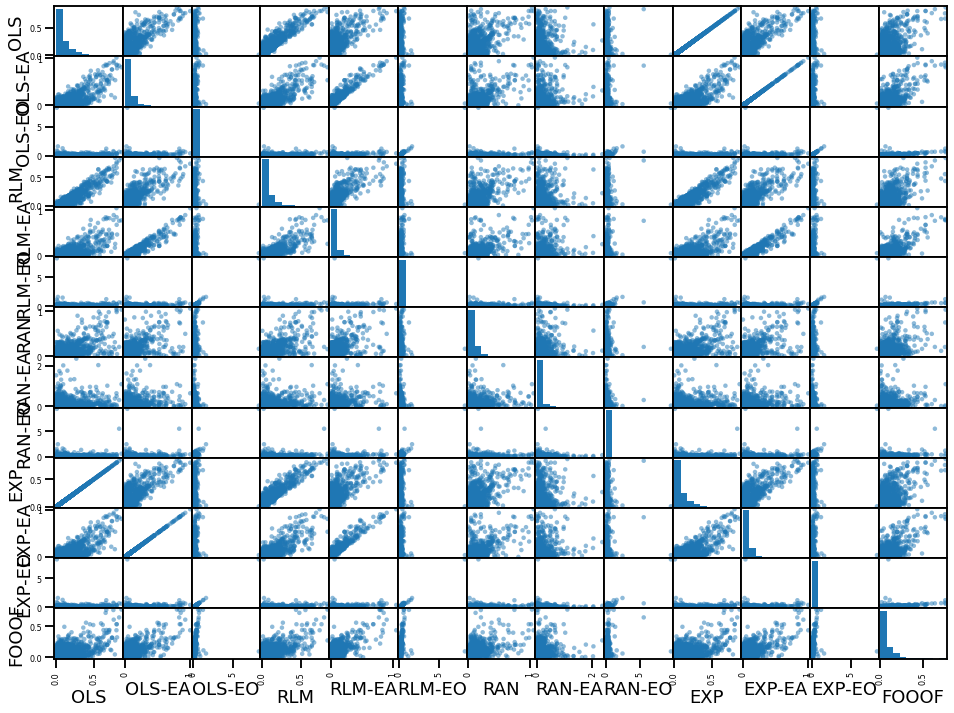

In [68]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(errors_df, figsize=[16, 12]);

In [76]:
# # Apply a normal test across fit-error distributions
# normalities = errors_df.apply(normaltest)

# # Check which results of normal test
# nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
# nt_df.style.applymap(color_red_or_green)

In [73]:
# Run comparisons between methods
comps = all_fits.compare_errors()

In [74]:
# Print out color-coded dataframe of comparison results
comps_df = pd.DataFrame(comps, index=all_fits.errors.keys(), columns=all_fits.errors.keys())
comps_df.style.applymap(color_red_or_green)

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000271,0.000000,0.000000,0.881630,0.000000,0.000000,0.000000
OLS-EA,0.000000,1.000000,0.000000,0.413692,0.000000,0.000000,0.000320,0.991338,0.027597,0.000000,0.880972,0.000000,0.000006
OLS-EO,0.000000,0.000000,1.000000,0.000063,0.100910,0.008567,0.000000,0.000002,0.008431,0.000000,0.000000,0.880162,0.730276
RLM,0.000000,0.413692,0.000063,1.000000,0.000000,0.000000,0.000030,0.374868,0.218018,0.000000,0.307620,0.000107,0.000499
RLM-EA,0.000000,0.000000,0.100910,0.000000,1.000000,0.326590,0.000000,0.000000,0.000034,0.000000,0.000000,0.071291,0.042395
RLM-EO,0.000000,0.000000,0.008567,0.000000,0.326590,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004731,0.002524
RAN,0.000271,0.000320,0.000000,0.000030,0.000000,0.000000,1.000000,0.000938,0.000000,0.000141,0.000726,0.000000,0.000000
RAN-EA,0.000000,0.991338,0.000002,0.374868,0.000000,0.000000,0.000938,1.000000,0.040174,0.000000,0.902394,0.000002,0.000007
RAN-EO,0.000000,0.027597,0.008431,0.218018,0.000034,0.000000,0.000000,0.040174,1.000000,0.000000,0.016567,0.010953,0.016063
EXP,0.881630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000141,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


## Conclusions

Overall, we can see the following patterns in these simulations:

Line fitting:
- In general, the methods perform quite similarly in terms of average error, but have different variances of the errors
- Standard robust fitting measures are not necessarily better for measuring aperiodic exponent
- Overall, the spectral parameterization approach offers low average error and few outliers